In [116]:
# import checkpoint as checkpoint
from ultralytics import YOLO
import models
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.ops import box_iou
import os
import json
from PIL import Image
import faiss
import argparse
from IPython.display import display
import matplotlib.pyplot as plt
import cv2

In [117]:
def parse_arguments():
    # Create an ArgumentParser object
    parser = argparse.ArgumentParser(description="SMS Inference",
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)

    # Define arguments
    parser.add_argument('--data_dir', type=str, help='path of data dir', default='/home/khaled/workspace/projects/shelf-monitoring/src/data/')
    parser.add_argument('--dataset', type=str, default='danbue')
    parser.add_argument('--camera_names', type=str, help='camera directory names', default='all')
    parser.add_argument('--device', type=str, help='torch device', default='cpu')
    parser.add_argument('--batch_size', type=int, help='batch size', default=256)
    parser.add_argument('--backbone', type=str, help='model architecture', default='resnet18')
    parser.add_argument('--feat_dim', type=int, help='size of projection head', default=512)
    parser.add_argument('--checkpoint', type=str, help='path to model weights', default='/home/khaled/workspace/projects/shelf-monitoring/src/weights/checkpoint_100.pth')
    parser.add_argument('--yolo_weights', type=str, help='path to YOLO weights', default='/home/khaled/workspace/projects/shelf-monitoring/src/weights/DavidK0-YOLOv8-small.pt')
    parser.add_argument('--iou_threshold', type=int, help='IoU threshold to between refernce box and query box. IoU less than this value will be make the query box as a gap', default=0.15)
    parser.add_argument('--k_max', type=int, help='Maximum number of nearest neighbors to consider during product feature matching', default=3)

    # Parse arguments from the command line
    opts = parser.parse_args([])  # Passing an empty list to simulate no command-line arguments

    return opts

In [167]:
def load_checkpoint(checkpoint_file, model, remove_fc=False):
    """Loads the checkpoint from the given file."""
    err_str = "Checkpoint '{}' not found"
    assert os.path.exists(checkpoint_file), err_str.format(checkpoint_file)
    # Load the checkpoint on CPU to avoid GPU mem spike
    checkpoint = torch.load(checkpoint_file, map_location="cpu")
    try:
        if 'state_dict' in checkpoint:
            state_dict = checkpoint["state_dict"]
        else:
            print("here")
            state_dict = checkpoint["model"]
    except KeyError:
        state_dict = checkpoint

    model_dict = model.state_dict()

    # Remove keys related to the classification layer from the checkpoint state dict
    if remove_fc:
        fc_keys = [key for key in state_dict.keys() if key.startswith('fc.')]
        for key in fc_keys:
            del state_dict[key]

    state_dict = {k : v for k, v in state_dict.items()}
    weight_dict = {k : v for k, v in state_dict.items() if k in model_dict and model_dict[k].size() == v.size()}

    model_dict.update(weight_dict)
    model.load_state_dict(model_dict)

    return checkpoint

In [174]:
def build_transforms():
    # Mean and std should be computed offline
    mean = (0.5525, 0.4640, 0.4124)
    std = (0.2703, 0.2622, 0.2679)
    resize_size = 256
    crop_size = 224

    return transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.Resize(resize_size),
        # transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])



def setup_model(cfg):
    model = models.SupConResNet()
    
    if cfg.checkpoint:
        load_checkpoint(cfg.checkpoint, model, remove_fc=False)


    if cfg.device == 'cuda' and torch.cuda.device_count() > 1:
        print(f"Using multiple CUDA devices ({torch.cuda.device_count()})")
        model = torch.nn.DataParallel(model)
    model = model.to(cfg.device)
    
    layers = torch.nn.Sequential(*list(model.children()))

    try:
        potential_last_layer = layers[-1]
        while not isinstance(potential_last_layer, nn.Linear):
            potential_last_layer = potential_last_layer[-1]
    except TypeError:
        raise TypeError('Can\'t find the linear layer of the model')
    
    cfg.feat_dim = potential_last_layer.in_features
    model = torch.nn.Sequential(*list(model.children())[:-1])
    
    return model

def build_model(cfg):
    model = models.SupConModel(cfg.backbone, num_classes=73)
    cfg.feat_dim = model.features_dim
    
    if cfg.checkpoint:
        print('checkpoint', cfg.checkpoint)
        model.load_checkpoint(cfg.checkpoint)


    if cfg.device == 'cuda' and torch.cuda.device_count() > 1:
        print(f"Using multiple CUDA devices ({torch.cuda.device_count()})")
        model = torch.nn.DataParallel(model)
    model = model.to(cfg.device)
    
    return model.encoder

def load_image(image_path):
    return Image.open(image_path)

def load_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

def evaluate():
    pass


In [175]:
import matplotlib.patches as patches

def plot_bounding_box(box, ax, color='r'):
    """Plot a bounding box on the given axis."""
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, linewidth=2)
    ax.add_patch(rect)
    

In [176]:
def find_misplaced_products(cfg, image, metadata, unique_idxs, detected_boxes, rf_boxes, feat_index, model, transform):
    plt.figure(figsize=(22, 22))
    # Plot original image
    plt.imshow(image)

    # Add misplaced boxes to the plot
    ax = plt.gca()
    misplaced_products_position = []
    with torch.no_grad():
        for q_idx, rf_idx in unique_idxs:
            q_box = detected_boxes[q_idx]
            rf_box = rf_boxes[rf_idx]
            rf_class = metadata[rf_idx]['id']


            # Determine the value of k based on the number of samples in the current class
            num_samples_in_class = sum(1 for entery in metadata if entery['id'] == rf_class)
            k = min(num_samples_in_class, cfg.k_max) if num_samples_in_class > 0 else 1

            q_img = image.crop(tuple(q_box.tolist()))
            q_feat = model(transform(q_img).unsqueeze(0)).detach().cpu()
            q_feat = F.normalize(q_feat, dim=1).squeeze().unsqueeze(0)
            topk_score, topk_idxs = feat_index.search(q_feat.numpy(), k)

            topk_classes = set()
            topk_rf_boxes = [rf_boxes[idx] for idx in topk_idxs][0]
            
            # import matplotlib.pyplot as plt
            # import matplotlib.patches as patches

            # # Assuming 'image' is your original image object
            # image_with_boxes = image.copy()

            # # Create figure and axes
            # fig, ax = plt.subplots(figsize=(22, 22))

            # # Display the image
            # ax.imshow(image_with_boxes)

            # # Plotting query box
            # q_xmin, q_ymin, q_xmax, q_ymax = q_box
            # rect_q = patches.Rectangle((q_xmin, q_ymin), q_xmax - q_xmin, q_ymax - q_ymin, linewidth=2, edgecolor='r', facecolor='none')
            # ax.add_patch(rect_q)

            # # Plotting reference box
            # rf_xmin, rf_ymin, rf_xmax, rf_ymax = rf_box
            # rect_rf = patches.Rectangle((rf_xmin, rf_ymin), rf_xmax - rf_xmin, rf_ymax - rf_ymin, linewidth=2, edgecolor='g', facecolor='none')
            # ax.add_patch(rect_rf)

            # # Plotting top-k boxes
            # print(topk_rf_boxes)
            # for topk_box in topk_rf_boxes:
            #     topk_xmin, topk_ymin, topk_xmax, topk_ymax = topk_box
            #     rect_topk = patches.Rectangle((topk_xmin, topk_ymin), topk_xmax - topk_xmin, topk_ymax - topk_ymin, linewidth=2, edgecolor='b', facecolor='none')
            #     ax.add_patch(rect_topk)

            # # Show plot
            # plt.axis('off')
            # plt.show()
            # break

            # for topk_box_set in topk_rf_boxes:
            for top_rf_box in topk_rf_boxes:
                top_rf_box = top_rf_box.view(1, 4)
                for rf_box_idx, box in enumerate(rf_boxes):
                    box = box.view(1, 4)
                    iou = box_iou(top_rf_box.cpu(), box.cpu()).item()
                    if iou >= cfg.iou_threshold:
                        topk_classes.add(metadata[rf_box_idx]["id"])

            if rf_class not in topk_classes:
                print(rf_class, topk_classes)
                misplaced_products_position.append(q_box)
            
            
        for box in misplaced_products_position:
            plot_bounding_box(box.squeeze(), ax, color='r')
            
        return torch.stack(misplaced_products_position)
    
def find_gaps(cfg, iou_mat, rf_boxes):
    mask = torch.any(iou_mat > cfg.iou_threshold, dim=0)
    indices = torch.nonzero(~mask)
    gaps = rf_boxes[indices]
    return gaps

In [177]:
def process_image(cfg, image, model, yolo_model, feat_index, rf_boxes, metadata, transform):
    image_res = yolo_model.predict(image, iou=0.5)
    detected_boxes = image_res[0].boxes.xyxy

    iou_mat = box_iou(detected_boxes, rf_boxes)
    indices = torch.nonzero(iou_mat >= cfg.iou_threshold, as_tuple=False)

    # Find unique indices with maximum IoU for each detected box
    unique_indices = {}
    for idx in indices:
        q_idx, rf_idx = idx.tolist()
        iou = iou_mat[q_idx, rf_idx].item()
        if q_idx not in unique_indices or iou > unique_indices[q_idx][0]:
            unique_indices[q_idx] = (iou, rf_idx)

    unique_indices = torch.tensor([[q_idx, rf_idx] for q_idx, (_, rf_idx) in unique_indices.items()])

    gaps_position = find_gaps(cfg, iou_mat, rf_boxes)

    misplaced_products_position = find_misplaced_products(cfg,
                                                          image, metadata,
                                                          unique_indices,
                                                          detected_boxes, rf_boxes,
                                                          feat_index,
                                                          model, transform)
    
    # print('Gaps', len(gaps_position))
    print('mis', len(misplaced_products_position))
    return None

In [178]:
def inference(cfg, model, yolo_model, transform):
    if cfg.camera_names == 'all':
        cfg.camera_names = [camera for camera in os.listdir(cfg.data_dir) if camera.startswith("camera")]
    elif not isinstance(cfg.camera_names, list):
        cfg.camera_names = [cfg.camera_names]

    for camera_name in cfg.camera_names[:1]:
        camera_dir = os.path.join(cfg.data_dir, camera_name)
        rf_image = load_image(os.path.join(camera_dir, 'reference.jpg')) # Ensure consistent refernce image names for all cameras
        metadata = load_json(os.path.join(camera_dir, 'metadata.json')) # Ensure consistent metadata file name for all cameras

        boxes = [[entery['box']['x1'], entery['box']['y1'], entery['box']['x2'], entery['box']['y2']] for entery in metadata]
        rf_boxes = torch.tensor(boxes)

        feat_index = faiss.IndexFlatIP(cfg.feat_dim)

        features = []
        with torch.no_grad():
            for box in rf_boxes:
                img = rf_image.crop(tuple(box.tolist()))
                feat = model(transform(img).unsqueeze(0)).squeeze().detach().cpu().numpy()
                features.append(feat)

        features = F.normalize(torch.tensor(features, dtype=torch.float32)) 

        feat_index.add(features.numpy())
        

        images_dir = os.path.join(camera_dir, 'images')
        for image_file in os.listdir(images_dir)[:1]:
            print(image_file)
            if image_file.endswith('.jpg'):
                image_path = os.path.join(images_dir, image_file)
                image = load_image(image_path)

                results = process_image(cfg, image, model, yolo_model, feat_index, rf_boxes, metadata, transform)

In [179]:
cfg = parse_arguments()
model = build_model(cfg)
model.eval()
yolo_model = YOLO(cfg.yolo_weights)
result = inference(cfg, model, yolo_model, transform=build_transforms())



checkpoint /home/khaled/workspace/projects/shelf-monitoring/src/weights/checkpoint_100.pth
ref1-mis88_jpg.rf.b4cfbe2eb07366cf34c138338e2d30e2.jpg


KeyboardInterrupt: 

In [96]:
checkpoint_path = '/home/khaled/workspace/projects/ucl/debiasing/weights/checkpoint_170.pth'

model = models.SupConResNet()

load_checkpoint(checkpoint_path, model, remove_fc=True)

layers = torch.nn.Sequential(*list(model.children()))

try:
    potential_last_layer = layers[-1]
    while not isinstance(potential_last_layer, nn.Linear):
        potential_last_layer = potential_last_layer[-1]
except TypeError:
    raise TypeError('Can\'t find the linear layer of the model')

features_dim = potential_last_layer.in_features
model = torch.nn.Sequential(*list(model.children())[:-1])

# cfg = parse_arguments()
# model = setup_model(cfg)
model.eval();

In [4]:
ref_img = Image.open('/home/khaled/workspace/projects/ucl/debiasing/data/camera_1/reference.jpg')

with open('/home/khaled/workspace/projects/ucl/debiasing/data/camera_1/metadata.json') as f:
    data = json.load(f)

boxes = [[instance['box']['x1'], instance['box']['y1'], instance['box']['x2'], instance['box']['y2']] for instance in data]
ref_boxes = torch.tensor(boxes)

trg_img = Image.open('/home/khaled/workspace/projects/ucl/debiasing/data/camera_1/images/ref1-mis102_jpg.rf.c443dd9eaa6a414811b877b07898dbf1.jpg')

yolo_model = YOLO('/home/khaled/workspace/projects/ucl/debiasing/weights/DavidK0-YOLOv8-small.pt')
trg_res = yolo_model.predict(trg_img, iou=0.5)  # return a list of Results objects
for result in trg_res:
    trg_boxes = result.boxes.xyxy


0: 384x640 158 objects, 381.6ms
Speed: 6.0ms preprocess, 381.6ms inference, 4.5ms postprocess per image at shape (1, 3, 384, 640)


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [5]:
def plot_bounding_box(box, ax, color='r'):
    """Plot a bounding box on the given axis."""
    x1, y1, x2, y2 = box
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor=color, linewidth=2)
    ax.add_patch(rect)

In [62]:
# fig, ax = plt.subplots(1, figsize=(22, 22))
# ax.imshow(trg_img)  # Assuming img2 is your image

# for box in ref_boxes:
#     plot_bounding_box(box, ax)

# for box in trg_boxes:
#     plot_bounding_box(box, ax, color='b')


In [ ]:
fig, ax = plt.subplots(1, figsize=(22, 22))
ax.imshow(trg_img)

iou_matrix = box_iou(ref_boxes, trg_boxes)

# match_idxs = torch.nonzero(iou_matrix >= 0.15, as_tuple=False)
mask = torch.any(iou_matrix > 0.5, dim=0)
indices = torch.nonzero(~mask)
gaps = ref_boxes[indices]
classes = [data[i]['class'] for i in indices]

for idx in indices:
    rf_box = ref_boxes[idx.item()]
    c = data[idx]['class']
    plot_bounding_box(rf_box, ax, color='b')
    ax.text(rf_box[0], rf_box[1], f'class: {c}', fontsize=10, color='k', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    

In [99]:
mean = (0.5732, 0.4699, 0.4269)
std = (0.2731, 0.2662, 0.2697)

resize_size = 224
crop_size = 224

T_test = transforms.Compose([
            transforms.Resize(resize_size),
            # transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

In [102]:
import os
import faiss

feat_index_path = "/home/khaled/workspace/projects/ucl/debiasing/data/camera_1/feat_index.index"

if not os.path.exists(feat_index_path):
    index = faiss.IndexFlatIP(512)

    features = []
    with torch.no_grad():
        for box in ref_boxes:
            img = ref_img.crop(tuple(box.tolist()))
            feat = model(T_test(img).unsqueeze(0)).squeeze().detach().cpu().numpy()
            features.append(feat)

    features = F.normalize(torch.tensor(features, dtype=torch.float32))

    index.add(features.numpy())

    faiss.write_index(index, feat_index_path)
else:
    index = faiss.read_index(feat_index_path)

In [127]:
iou_matrix = box_iou(trg_boxes, ref_boxes)
indices = torch.nonzero(iou_matrix >= 0.15, as_tuple=False)

unique_indices = []
max_iou_dict = {}

for idx in indices:
    trg_idx, ref_idx = idx.tolist()
    iou = iou_matrix[trg_idx, ref_idx].item()
    if trg_idx in max_iou_dict:
        if iou == max_iou_dict[trg_idx][0]:
          print(f"iou {iou}, max_iou {max_iou_dict[trg_idx][0]}")
        if iou > max_iou_dict[trg_idx][0]:
            max_iou_dict[trg_idx] = (iou, ref_idx)
    else:
        max_iou_dict[trg_idx] = (iou, ref_idx)

for trg_idx, (iou, ref_idx) in max_iou_dict.items():
    unique_indices.append([trg_idx, ref_idx])

unique_indices = torch.tensor(unique_indices)

misplaced_boxes = []
k_max = 3
with torch.no_grad():
    for trg_idx, ref_idx in unique_indices:
        trg_box = trg_boxes[trg_idx]
        ref_box = ref_boxes[ref_idx]
        ref_class = data[ref_idx]['class']
        
        # Determine the value of k based on the number of samples in the current class
        num_samples_in_class = len([d for d in data if d['class'] == ref_class])
        k = min(num_samples_in_class, k_max) if num_samples_in_class > 0 else 1
        k = k_max

        trg_im = trg_img.crop(tuple(trg_box.tolist()))
        trg_feat = model(T_test(trg_im).unsqueeze(0)).detach().cpu()
        trg_feat = F.normalize(trg_feat, dim=1).squeeze().unsqueeze(0)



        # ref_im = ref_img.crop(tuple(ref_box.tolist()))
        # ref_feat = model(T_test(ref_im).unsqueeze(0)).detach().cpu()
        # ref_feat = F.normalize(ref_feat, dim=1).squeeze().unsqueeze(0)

        # score = F.cosine_similarity(ref_feat, trg_feat)

        # misplaced_boxes.append({"ref_box": ref_box,
        #                         "trg_box": trg_box,
        #                         "score": score.squeeze().item()})


        topk_score, topk_idxs = index.search(trg_feat.numpy(), k)

        misplaced_boxes.append({"ref_box": ref_box,
                                "trg_box": trg_box,
                                "class": data[ref_idx]['class'],
                                "topk_boxes": [ref_boxes[idx] for idx in topk_idxs], #[ref_aug_boxes[idx] for idx in topk_idxs]
                                "topk_scores": topk_score})

In [ ]:
13
28
51
133
148

42 [5, 42, 5, 5]


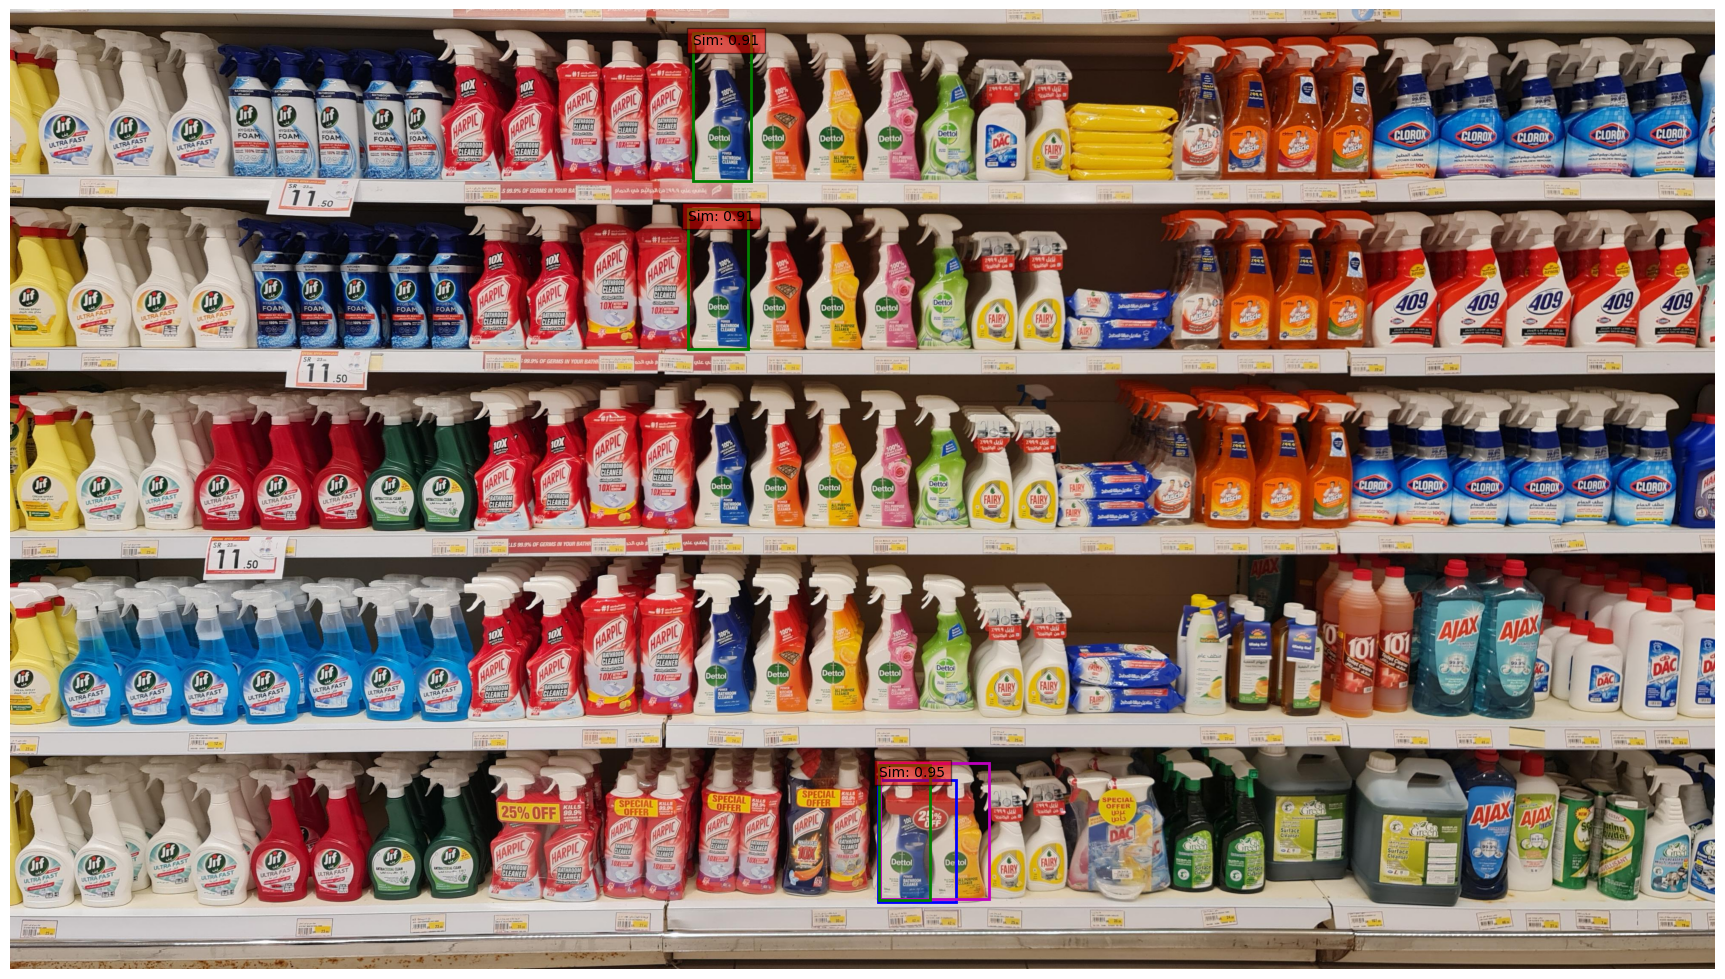

In [143]:
import matplotlib.patches as patches

plt.figure(figsize=(22, 22))
# Plot original image
plt.imshow(trg_img)

# Add misplaced boxes to the plot
ax = plt.gca()
i = 150
for j, d in enumerate(misplaced_boxes[i:i+1]):

    x, y, w, h = d['trg_box'].tolist()
    rect = patches.Rectangle((x, y), w - x, h - y, linewidth=2, edgecolor='b', facecolor='none')
    ax.add_patch(rect)
    # ax.text(x, y, f'Sim: {d["score"]:.2f}', fontsize=10, color='k', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    threshold = 0.15
    topk_classes = []

    for topk_box_set in d['topk_boxes']:
        for topk_box in topk_box_set:
            for obj in data:
                topk_box = topk_box.view(1, 4)
                data_box = torch.tensor(list(obj["box"].values())).view(1, 4)

                iou = box_iou(topk_box.cpu(), data_box.cpu()).item()

                if iou >= 0.15:
                    # print(iou)
                    topk_classes.append(obj["class"])
                    # x, y, w, h = data_box.unbind(1)
                    # rect = patches.Rectangle((x, y), w - x, h - y, linewidth=2, edgecolor='k', facecolor='none')
                    # ax.add_patch(rect)

    print(d['class'], topk_classes)
    # if d['class'] not in topk_classes:
    #   print(j)
    #   x, y, w, h = d['trg_box'].tolist()
    #   rect = patches.Rectangle((x, y), w - x, h - y, linewidth=2, edgecolor='b', facecolor='none')
    #   ax.add_patch(rect)

    x, y, w, h = d['ref_box'].tolist()
    rect = patches.Rectangle((x, y), w - x, h - y, linewidth=2, edgecolor='m', facecolor='none')
    ax.add_patch(rect)
    # ax.text(x, y, f'Sim: {score:.2f}', fontsize=10, color='k', verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    for box, s in zip(d['topk_boxes'][0], d['topk_scores'][0]):
        x, y, w, h = box.tolist()
        rect = patches.Rectangle((x, y), w - x, h - y, linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, f'Sim: {s:.2f}', fontsize=10, color='k', verticalalignment='top', bbox=dict(facecolor='red', alpha=0.5))


plt.axis('off')
plt.show()